In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram

In [2]:
# Load CSV files
agg_df = pd.read_csv('pandas/agg_df.csv')
fish_df = pd.read_csv('pandas/fish_df.csv')

# <a id='toc2_'></a>[Agglomerative  Cluster Analysis](#toc0_)
## <a id='toc2_1_'></a>[Outliers](#toc0_)
We first do a hierarchical clustering to identify outliers in the data. We select a threshold distance to cut the dendrogram and identify clusters. Cluster size less than 2% of total samples are considered outliers.

To stay consistent with previous ecological analyses we will only use the Jaccard distance metric for clustering.

In [3]:
fish_df_binary = (fish_df > 0).astype(np.int8)
fish_df_binary.head()

,BMBF,WTCP,BKCP,LGPH,MMSN,WDSN,YWPH,BKSS,SHRH,SVRH,...,CNCF,WLYE,GZSD,CARP,LMBS,RVSN,RKBS,BHMW,STSN,WTBS
0,0,0,1,0,0,1,1,0,0,0,...,0,1,1,0,0,0,0,0,0,0
1,0,0,0,1,0,0,1,0,1,1,...,1,1,1,0,0,0,0,0,1,1
2,0,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,1,0,0,1,...,0,0,0,0,1,0,0,0,0,0


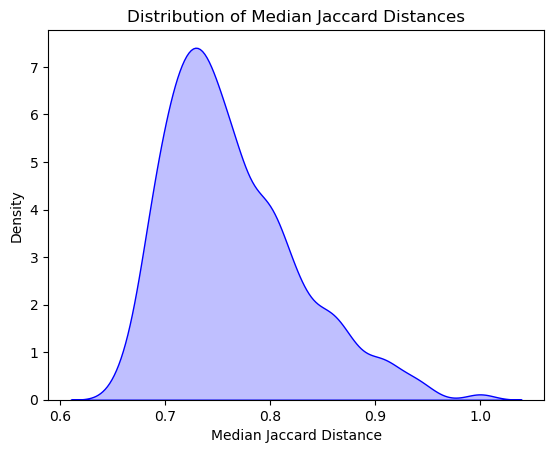

In [4]:
dist_matrix_jac = pdist(fish_df_binary, metric='jaccard') 
dist_df_jac = pd.DataFrame(squareform(dist_matrix_jac))

sns.kdeplot(dist_df_jac.median(axis=0), fill=True, color="blue")
plt.xlabel("Median Jaccard Distance")
plt.ylabel("Density")
plt.title("Distribution of Median Jaccard Distances")
plt.show()

# Clustering 1: All samples

In [6]:
import numpy as np
import fastcluster
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.metrics import silhouette_score

# 0/1 presence
D_all = pdist(fish_df_binary, metric='jaccard')
Z_all = fastcluster.linkage(D_all, method='average')

# Mojena cut suggestions
heights = Z_all[:,2]
mu, sd = heights.mean(), heights.std()
for c in [1.25, 1.5, 2.0]:
    t_moj = mu + c*sd
    k_moj = (heights < t_moj).sum() + 1
    print(f"Mojena c={c}: cut≈{t_moj:.4f}, proposed k={k_moj}")

# Silhouette across k (Jaccard)
for k in range(2, 15):
    labels = fcluster(Z_all, t=k, criterion='maxclust')
    sil = silhouette_score(squareform(D_all), labels, metric='precomputed')
    print(f"k={k}: mean silhouette={sil:.3f}")

Mojena c=1.25: cut≈0.5831, proposed k=2156
Mojena c=1.5: cut≈0.6218, proposed k=2241
Mojena c=2.0: cut≈0.6991, proposed k=2343
k=2: mean silhouette=0.237
k=3: mean silhouette=0.225
k=4: mean silhouette=0.209
k=5: mean silhouette=0.195
k=6: mean silhouette=0.185
k=7: mean silhouette=0.157
k=8: mean silhouette=0.133
k=9: mean silhouette=0.113
k=10: mean silhouette=0.109
k=11: mean silhouette=0.094
k=12: mean silhouette=0.083
k=13: mean silhouette=0.087
k=14: mean silhouette=0.087


{'icoord': [[5.0, 5.0, 15.0, 15.0],
  [75.0, 75.0, 85.0, 85.0],
  [105.0, 105.0, 115.0, 115.0],
  [95.0, 95.0, 110.0, 110.0],
  [80.0, 80.0, 102.5, 102.5],
  [125.0, 125.0, 135.0, 135.0],
  [91.25, 91.25, 130.0, 130.0],
  [65.0, 65.0, 110.625, 110.625],
  [145.0, 145.0, 155.0, 155.0],
  [165.0, 165.0, 175.0, 175.0],
  [150.0, 150.0, 170.0, 170.0],
  [195.0, 195.0, 205.0, 205.0],
  [185.0, 185.0, 200.0, 200.0],
  [160.0, 160.0, 192.5, 192.5],
  [215.0, 215.0, 225.0, 225.0],
  [235.0, 235.0, 245.0, 245.0],
  [255.0, 255.0, 265.0, 265.0],
  [275.0, 275.0, 285.0, 285.0],
  [260.0, 260.0, 280.0, 280.0],
  [305.0, 305.0, 315.0, 315.0],
  [295.0, 295.0, 310.0, 310.0],
  [270.0, 270.0, 302.5, 302.5],
  [325.0, 325.0, 335.0, 335.0],
  [385.0, 385.0, 395.0, 395.0],
  [375.0, 375.0, 390.0, 390.0],
  [365.0, 365.0, 382.5, 382.5],
  [355.0, 355.0, 373.75, 373.75],
  [345.0, 345.0, 364.375, 364.375],
  [330.0, 330.0, 354.6875, 354.6875],
  [415.0, 415.0, 425.0, 425.0],
  [435.0, 435.0, 445.0, 445.0]

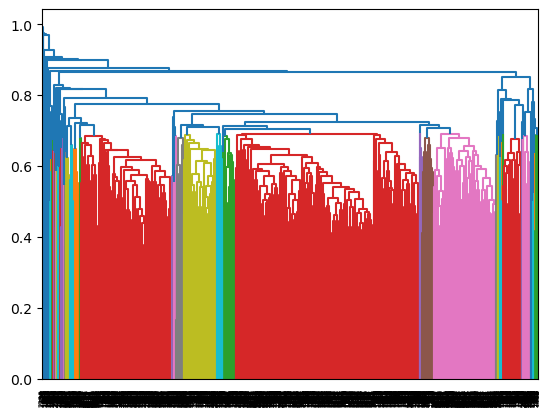

In [10]:
linked_jaccard = linkage(dist_matrix_jac, method='average')

plt.figure(figsize=(15, 5))
dendrogram(linked_jaccard)

In [8]:
from joblib import Parallel, delayed
import fastcluster  # faster C++ linkage implementation (same API shape)
from sklearn.metrics import adjusted_rand_score

thresholds = np.arange(0.70, 0.90, 0.01)
n_bootstrap = 1000
sample_frac = 0.80
n_samples = len(fish_df)
sample_size = int(n_samples * sample_frac)

# Precompute full linkage and labels for every threshold once
full_dist = pdist(fish_df.values.astype(int), metric='jaccard')
# use fastcluster.linkage if available for speed
full_linkage = fastcluster.linkage(full_dist, method='average')  # returns condensed linkage
full_labels_by_threshold = {t: fcluster(full_linkage, t=t, criterion='distance') for t in thresholds}

def one_bootstrap(seed):
    rng = np.random.default_rng(seed)
    idx = rng.choice(n_samples, size=sample_size, replace=False)
    sub_data = fish_df.iloc[idx].values.astype(int)
    sub_dist = pdist(sub_data, metric='jaccard')
    sub_linkage = fastcluster.linkage(sub_dist, method='average')
    # compute ARI for each threshold comparing sub_labels to full_labels restricted to idx
    ari_list = []
    num_clusters = []
    cluster_size_cvs = []
    for t in thresholds:
        sub_labels = fcluster(sub_linkage, t=t, criterion='distance')
        # compare to full labels computed earlier for the same t
        full_labels = full_labels_by_threshold[t][idx]
        ari_list.append(adjusted_rand_score(full_labels, sub_labels))
        num_clusters.append(len(np.unique(sub_labels)))
        cs = pd.Series(sub_labels).value_counts()
        cluster_size_cvs.append(cs.std() / cs.mean())
    return {'ari': np.array(ari_list), 'num_clusters': np.array(num_clusters), 'cluster_size_cvs': np.array(cluster_size_cvs)}

# Run bootstraps in parallel (adjust n_jobs to CPU cores)
results = Parallel(n_jobs=8, backend='loky')(delayed(one_bootstrap)(seed) for seed in range(n_bootstrap))

# Aggregate per-threshold results
aris = np.vstack([r['ari'] for r in results])            # shape (n_bootstrap, n_thresholds)
num_clusters = np.vstack([r['num_clusters'] for r in results])
cluster_cvs = np.vstack([r['cluster_size_cvs'] for r in results])

mean_ari = aris.mean(axis=0)
std_ari = aris.std(axis=0)
cv_ari = std_ari / mean_ari
mean_num_clusters = num_clusters.mean(axis=0)
std_num_clusters = num_clusters.std(axis=0)
mean_cluster_size_cv = cluster_cvs.mean(axis=0)
# Compile results into DataFrame
stability_results = []
for i, threshold in enumerate(thresholds):
    # Get full dataset clustering (already computed in full_labels_by_threshold)
    labels = full_labels_by_threshold[threshold]
    cluster_sizes = pd.Series(labels).value_counts()
    
    stability_results.append({
        'threshold': threshold,
        'num_clusters': len(cluster_sizes),
        'num_large_clusters': (cluster_sizes >= 1000).sum(),
        'mean_ari': mean_ari[i],
        'std_ari': std_ari[i],
        'cv_ari': cv_ari[i] if mean_ari[i] > 0 else np.inf,
        'mean_num_clusters': mean_num_clusters[i],
        'std_num_clusters': std_num_clusters[i],
        'mean_cluster_size_cv': mean_cluster_size_cv[i]
    })

stability_df = pd.DataFrame(stability_results)
# -----------------------------------------------

RESULTS: Most Stable Thresholds

1. HIGHEST STABILITY (Mean ARI):
   Threshold: 0.810
   Mean ARI: 0.6691 ± 0.0797
   Number of clusters: 23
   Large clusters (≥1000): 3

2. MOST CONSISTENT (Lowest CV of ARI):
   Threshold: 0.740
   CV of ARI: 0.0940
   Mean ARI: 0.5166 ± 0.0486
   Number of clusters: 44

3. BEST OVERALL BALANCE:
   Threshold: 0.890
   Mean ARI: 0.6365 ± 0.1376
   CV of ARI: 0.2162
   Number of clusters: 11
   Large clusters (≥10): 1


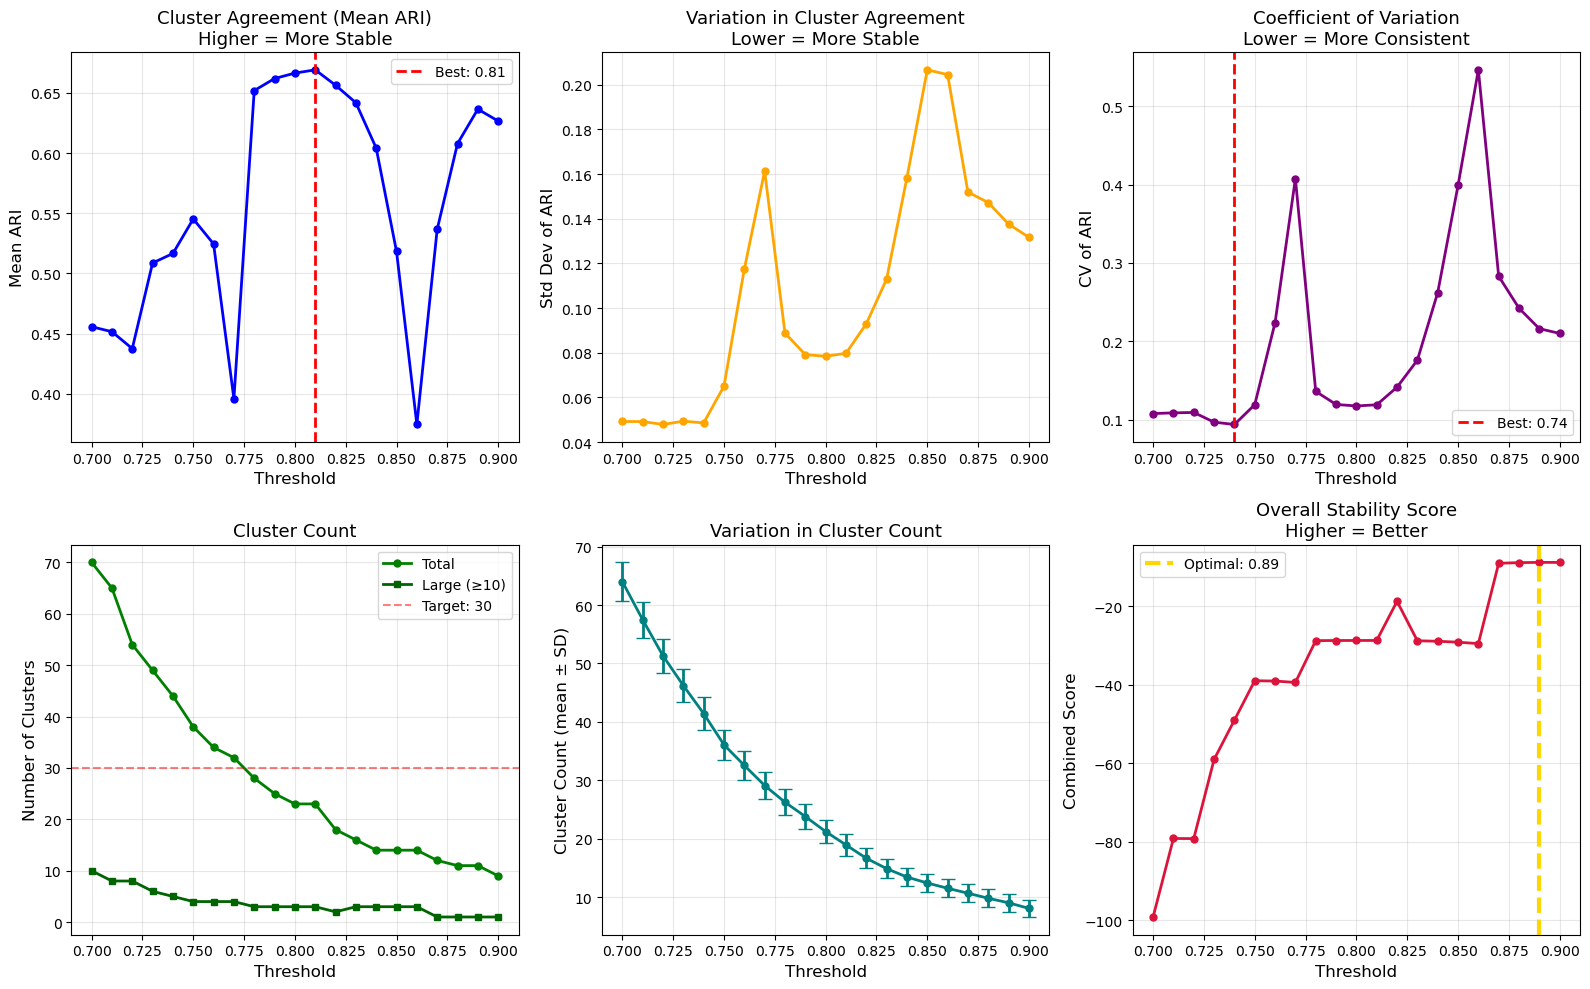

🎯 RECOMMENDATION:
   Use threshold = 0.890 for maximum stability
   This produces 1 large clusters with
   Mean ARI = 0.6365 (closer to 1.0 = more stable)


In [17]:
# Find optimal thresholds
print("=" * 80)
print("RESULTS: Most Stable Thresholds")
print("=" * 80)

# 1. Highest mean ARI (best agreement with full clustering)
best_ari = stability_df.loc[stability_df['mean_ari'].idxmax()]
print(f"\n1. HIGHEST STABILITY (Mean ARI):")
print(f"   Threshold: {best_ari['threshold']:.3f}")
print(f"   Mean ARI: {best_ari['mean_ari']:.4f} ± {best_ari['std_ari']:.4f}")
print(f"   Number of clusters: {best_ari['num_clusters']:.0f}")
print(f"   Large clusters (≥1000): {best_ari['num_large_clusters']:.0f}")

# 2. Lowest coefficient of variation in ARI (most consistent)
best_cv = stability_df.loc[stability_df['cv_ari'].idxmin()]
print(f"\n2. MOST CONSISTENT (Lowest CV of ARI):")
print(f"   Threshold: {best_cv['threshold']:.3f}")
print(f"   CV of ARI: {best_cv['cv_ari']:.4f}")
print(f"   Mean ARI: {best_cv['mean_ari']:.4f} ± {best_cv['std_ari']:.4f}")
print(f"   Number of clusters: {best_cv['num_clusters']:.0f}")

# 3. Best balance (high ARI + low CV + reasonable cluster count)
stability_df['combined_score'] = (
    stability_df['mean_ari'] * 2 -  # Maximize agreement
    stability_df['cv_ari'] * 0.5 
    # -  # Minimize variation
    - stability_df['num_large_clusters'] * 10  # Penalize too many large clusters 
    
    #     - abs(stability_df['num_large_clusters'] - 30) * 2  # Prefer ~15 large clusters
)

best_combined = stability_df.loc[stability_df['combined_score'].idxmax()]
print(f"\n3. BEST OVERALL BALANCE:")
print(f"   Threshold: {best_combined['threshold']:.3f}")
print(f"   Mean ARI: {best_combined['mean_ari']:.4f} ± {best_combined['std_ari']:.4f}")
print(f"   CV of ARI: {best_combined['cv_ari']:.4f}")
print(f"   Number of clusters: {best_combined['num_clusters']:.0f}")
print(f"   Large clusters (≥10): {best_combined['num_large_clusters']:.0f}")

# Visualization
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# Plot 1: Mean ARI (higher is better)
axes[0, 0].plot(stability_df['threshold'], stability_df['mean_ari'], 
                'b-o', markersize=5, linewidth=2)
axes[0, 0].axvline(best_ari['threshold'], color='red', linestyle='--', 
                   linewidth=2, label=f"Best: {best_ari['threshold']:.2f}")
axes[0, 0].set_xlabel('Threshold', fontsize=12)
axes[0, 0].set_ylabel('Mean ARI', fontsize=12)
axes[0, 0].set_title('Cluster Agreement (Mean ARI)\nHigher = More Stable', fontsize=13)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Std Dev of ARI (lower is better)
axes[0, 1].plot(stability_df['threshold'], stability_df['std_ari'], 
                'orange', marker='o', markersize=5, linewidth=2)
axes[0, 1].set_xlabel('Threshold', fontsize=12)
axes[0, 1].set_ylabel('Std Dev of ARI', fontsize=12)
axes[0, 1].set_title('Variation in Cluster Agreement\nLower = More Stable', fontsize=13)
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Coefficient of Variation (lower is better)
axes[0, 2].plot(stability_df['threshold'], stability_df['cv_ari'], 
                'purple', marker='o', markersize=5, linewidth=2)
axes[0, 2].axvline(best_cv['threshold'], color='red', linestyle='--', 
                   linewidth=2, label=f"Best: {best_cv['threshold']:.2f}")
axes[0, 2].set_xlabel('Threshold', fontsize=12)
axes[0, 2].set_ylabel('CV of ARI', fontsize=12)
axes[0, 2].set_title('Coefficient of Variation\nLower = More Consistent', fontsize=13)
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# Plot 4: Number of clusters
axes[1, 0].plot(stability_df['threshold'], stability_df['num_clusters'], 
                'g-o', markersize=5, linewidth=2, label='Total')
axes[1, 0].plot(stability_df['threshold'], stability_df['num_large_clusters'], 
                'darkgreen', marker='s', markersize=5, linewidth=2, label='Large (≥10)')
axes[1, 0].axhline(30, color='red', linestyle='--', alpha=0.5, label='Target: 30')
axes[1, 0].set_xlabel('Threshold', fontsize=12)
axes[1, 0].set_ylabel('Number of Clusters', fontsize=12)
axes[1, 0].set_title('Cluster Count', fontsize=13)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 5: Stability of cluster count
axes[1, 1].errorbar(stability_df['threshold'], stability_df['mean_num_clusters'],
                    yerr=stability_df['std_num_clusters'], fmt='o-', 
                    capsize=5, markersize=5, linewidth=2, color='teal')
axes[1, 1].set_xlabel('Threshold', fontsize=12)
axes[1, 1].set_ylabel('Cluster Count (mean ± SD)', fontsize=12)
axes[1, 1].set_title('Variation in Cluster Count', fontsize=13)
axes[1, 1].grid(True, alpha=0.3)

# Plot 6: Combined score
axes[1, 2].plot(stability_df['threshold'], stability_df['combined_score'], 
                'crimson', marker='o', markersize=5, linewidth=2)
axes[1, 2].axvline(best_combined['threshold'], color='gold', linestyle='--', 
                   linewidth=3, label=f"Optimal: {best_combined['threshold']:.2f}")
axes[1, 2].set_xlabel('Threshold', fontsize=12)
axes[1, 2].set_ylabel('Combined Score', fontsize=12)
axes[1, 2].set_title('Overall Stability Score\nHigher = Better', fontsize=13)
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("🎯 RECOMMENDATION:")
print(f"   Use threshold = {best_combined['threshold']:.3f} for maximum stability")
print(f"   This produces {best_combined['num_large_clusters']:.0f} large clusters with")
print(f"   Mean ARI = {best_combined['mean_ari']:.4f} (closer to 1.0 = more stable)")

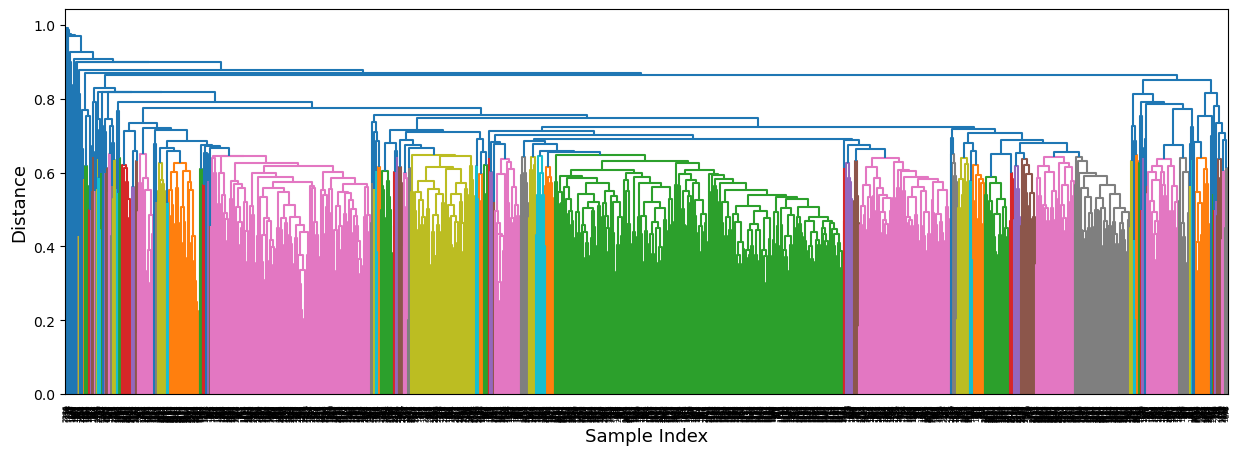


=== CLUSTER SUMMARY (threshold=0.65) ===
Total clusters: 121
Clusters with >1000 samples: 0
Clusters with >30 samples: 13

Cluster sizes:
cluster
1     599
2     332
3     190
4     135
5     115
6      80
7      67
8      65
9      53
10     53
11     35
12     34
13     31
14     27
16     26
15     26
17     22
18     21
19     20
20     19
21     18
22     17
23     17
24     15
25     15
26     12
27     11
28     11
29     11
31     10
dtype: int64


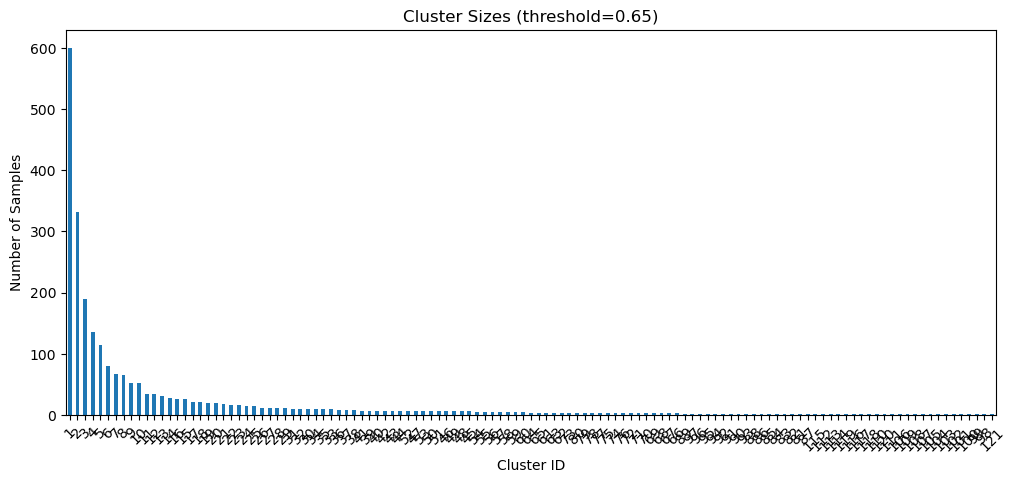

In [25]:
from scipy.cluster.hierarchy import dendrogram 

linked_jaccard = linkage(dist_matrix_jac, method='average')

cluster_threshold = 0.65
plt.figure(figsize=(15, 5))
dendrogram(linked_jaccard, color_threshold=cluster_threshold) # you can change this value to change the number of clusters you get
plt.xlabel("Sample Index", fontsize=13)
plt.ylabel("Distance", fontsize=13)
plt.show()

# First assign clusters using fcluster
agg_df['cluster'] = fcluster(linked_jaccard, t=cluster_threshold, criterion='distance')
fish_df['cluster'] = agg_df['cluster']

# Then reassign cluster numbers in order by cluster size (largest = 1)
cluster_sizes = agg_df['cluster'].value_counts().sort_values(ascending=False)
cluster_map = {old: new for new, old in enumerate(cluster_sizes.index, 1)}
agg_df['cluster'] = agg_df['cluster'].map(cluster_map)
fish_df['cluster'] = agg_df['cluster']

# Summary of clusters
cluster_summary = agg_df.groupby('cluster').size().sort_values(ascending=False)
print(f"\n=== CLUSTER SUMMARY (threshold={cluster_threshold}) ===")
print(f"Total clusters: {len(cluster_summary)}")
print(f"Clusters with >1000 samples: {(cluster_summary >= 1000).sum()}")
print(f"Clusters with >30 samples: {(cluster_summary >= 30).sum()}")
print(f"\nCluster sizes:")
print(cluster_summary.head(30))

# Visualize cluster size distribution
plt.figure(figsize=(12, 5))
cluster_summary.plot(kind='bar')
plt.xlabel('Cluster ID')
plt.ylabel('Number of Samples')
plt.title(f'Cluster Sizes (threshold={cluster_threshold})')
plt.xticks(rotation=45);
#print(agg_df.groupby('cluster').size())

In [55]:
# Save for heatmap in 3cluster_visualization
agg_df.to_csv('pandas/agg_df_cluster1.csv', index=False)
fish_df.to_csv('pandas/fish_df_cluster1.csv', index=False)

# Alternative theshold determination

In [5]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.metrics import adjusted_rand_score
from collections import Counter
from tqdm import tqdm

# --- helpers reused ---
def labels_at_threshold(Z, t, n):
    return fcluster(Z, t=t, criterion='distance')

def cluster_sizes_from_labels(labels):
    counts = Counter(labels)
    return np.array(list(counts.values()), dtype=int)

def variation_of_information(labels_a, labels_b):
    _, la = np.unique(labels_a, return_inverse=True)
    _, lb = np.unique(labels_b, return_inverse=True)
    n = len(la)
    joint_index = la * (lb.max() + 1) + lb
    joint = np.bincount(joint_index, minlength=(la.max()+1)*(lb.max()+1)).reshape(la.max()+1, lb.max()+1)
    Pab = joint / n
    Pa = Pab.sum(axis=1, keepdims=True)
    Pb = Pab.sum(axis=0, keepdims=True)

    def H(p):
        p = p[p > 0]
        return -np.sum(p * np.log(p))

    Ha = H(Pa.ravel())
    Hb = H(Pb.ravel())
    mask = Pab > 0
    MI = np.sum(Pab[mask] * (np.log(Pab[mask]) - np.log(Pa.repeat(Pb.shape[1], axis=1)[mask]) - np.log(Pb.repeat(Pa.shape[0], axis=0)[mask])))
    return (Ha + Hb) - 2 * MI

def threshold_grid_from_linkage(Z_full, n_thresholds=50, t_low=None, t_high=None, q_low=0.05, q_high=0.95):
    heights = Z_full[:, 2]
    if (t_low is not None) and (t_high is not None):
        lo = max(heights.min(), t_low)
        hi = min(heights.max(), t_high)
        thr = np.linspace(lo, hi, n_thresholds)
    else:
        qs = np.linspace(q_low, q_high, n_thresholds)
        thr = np.quantile(heights, qs)
    thr = np.unique(np.clip(thr, heights.min(), heights.max()))
    return thr

def minmax_norm(vals_dict):
    keys = list(vals_dict.keys())
    vals = np.array([vals_dict[k] for k in keys], dtype=float)
    vmin, vmax = vals.min(), vals.max()
    if vmax == vmin:
        return {k: 0.0 for k in keys}
    norm = (vals - vmin) / (vmax - vmin)
    return {k: v for k, v in zip(keys, norm)}

# --- NEW: size shortfall ---
def size_shortfall(sizes, target):
    # Sum of how far small clusters fall below the target, normalized by target
    deficits = np.maximum(0, target - sizes)
    return float(deficits.sum()) / float(target)

def select_clustering_threshold(
    X_binary,
    n_boot=1000,
    sample_frac=0.8,
    n_thresholds=50,
    # size rules
    small_min=30,            # clusters < small_min are "small"
    big_max=1000,            # hard cap on max cluster size
    max_small_clusters=0,    # NEW: hard cap on number of small clusters (0 = none allowed)
    # scoring weights
    w_instability=1.0,       # instability (1 - ARI to full) across bootstraps
    w_volatility=0.5,        # VI between adjacent thresholds (full data)
    w_small_full=0.6,        # NEW: penalty weight for # of small clusters (full data)
    w_shortfall_full=0.6,    # NEW: penalty weight for size shortfall (full data)
    w_small_boot=0.4,        # NEW: penalty weight for mean # small clusters in bootstraps
    w_shortfall_boot=0.4,    # NEW: penalty weight for mean size shortfall in bootstraps
    # threshold range (absolute)
    t_low=0.6,
    t_high=0.9,
    random_state=42,
    show_progress=True
):
    """
    Returns: best_threshold, metrics_df, labels_at_best (full-data labels)
    """
    rng = np.random.default_rng(random_state)
    n = X_binary.shape[0]

    # 1) Full-data Jaccard distance and linkage
    D_full = pdist(X_binary.astype(bool), metric='jaccard')
    Z_full = linkage(D_full, method='average')

    # 2) Candidate thresholds restricted to [t_low, t_high]
    thresholds = threshold_grid_from_linkage(
        Z_full, n_thresholds=n_thresholds, t_low=t_low, t_high=t_high
    )

    # 3) Full-data partitions and size metrics
    full_labels_by_t = {}
    volatility = {}
    n_small_full = {}
    shortfall_full = {}
    max_size_full = {}

    for i, t in enumerate(thresholds):
        labels = labels_at_threshold(Z_full, t, n=n)
        full_labels_by_t[t] = labels
        sizes = cluster_sizes_from_labels(labels)
        n_small_full[t] = int(np.sum(sizes < small_min))
        shortfall_full[t] = size_shortfall(sizes, small_min)
        max_size_full[t] = int(sizes.max()) if sizes.size else 0

    # Volatility as VI to neighbors
    for i, t in enumerate(thresholds):
        if i == 0:
            vi = variation_of_information(full_labels_by_t[thresholds[i]], full_labels_by_t[thresholds[i+1]])
        elif i == len(thresholds) - 1:
            vi = variation_of_information(full_labels_by_t[thresholds[i]], full_labels_by_t[thresholds[i-1]])
        else:
            vi_prev = variation_of_information(full_labels_by_t[thresholds[i]], full_labels_by_t[thresholds[i-1]])
            vi_next = variation_of_information(full_labels_by_t[thresholds[i]], full_labels_by_t[thresholds[i+1]])
            vi = 0.5 * (vi_prev + vi_next)
        volatility[t] = vi

    # 4) Bootstrap instability and bootstrap size metrics
    instability_sum = {t: 0.0 for t in thresholds}
    n_small_boot_sum = {t: 0.0 for t in thresholds}
    shortfall_boot_sum = {t: 0.0 for t in thresholds}

    small_min_boot = int(round(sample_frac * small_min))

    boot_iter = range(n_boot)
    if show_progress:
        boot_iter = tqdm(boot_iter, desc="Bootstraps", unit="rep")

    for _ in boot_iter:
        idx = rng.choice(n, size=int(np.floor(n * sample_frac)), replace=False)
        Xb = X_binary[idx, :]
        Db = pdist(Xb.astype(bool), metric='jaccard')
        Zb = linkage(Db, method='average')

        for t in thresholds:
            lb_sub = labels_at_threshold(Zb, t, n=len(idx))
            lf_full = full_labels_by_t[t][idx]
            ari = adjusted_rand_score(lf_full, lb_sub)
            instability_sum[t] += (1.0 - ari)

            sizes_b = cluster_sizes_from_labels(lb_sub)
            n_small_boot_sum[t] += np.sum(sizes_b < small_min_boot)
            shortfall_boot_sum[t] += size_shortfall(sizes_b, small_min_boot)

    instability = {t: instability_sum[t] / n_boot for t in thresholds}
    n_small_boot_mean = {t: n_small_boot_sum[t] / n_boot for t in thresholds}
    shortfall_boot_mean = {t: shortfall_boot_sum[t] / n_boot for t in thresholds}

    # 5) Normalization and scoring with hard constraints
    inst_norm = minmax_norm(instability)
    vol_norm  = minmax_norm(volatility)
    small_full_norm = minmax_norm(n_small_full)
    shortfall_full_norm = minmax_norm(shortfall_full)
    small_boot_norm = minmax_norm(n_small_boot_mean)
    shortfall_boot_norm = minmax_norm(shortfall_boot_mean)

    scores = {}
    for t in thresholds:
        # Hard constraints
        if max_size_full[t] > big_max:
            scores[t] = 1e12 + (max_size_full[t] - big_max)  # reject
            continue
        if n_small_full[t] > max_small_clusters:  # NEW: hard cap on small clusters
            # strong, but not "infinite" penalty so ties can still resolve
            scores[t] = 1e9 + (n_small_full[t] - max_small_clusters)
            continue

        # Composite score with stronger emphasis on small clusters
        s = (
            w_instability * inst_norm[t]
            + w_volatility * vol_norm[t]
            + w_small_full * small_full_norm[t]
            + w_shortfall_full * shortfall_full_norm[t]
            + w_small_boot * small_boot_norm[t]
            + w_shortfall_boot * shortfall_boot_norm[t]
        )
        scores[t] = s

    best_t = min(scores, key=scores.get)
    best_labels = full_labels_by_t[best_t]

    metrics = pd.DataFrame({
        "threshold": thresholds,
        "instability_1_minus_ARI": [instability[t] for t in thresholds],
        "volatility_VI_neighbor": [volatility[t] for t in thresholds],
        "n_small_clusters_full": [n_small_full[t] for t in thresholds],
        "size_shortfall_full": [shortfall_full[t] for t in thresholds],
        "n_small_clusters_boot_mean": [n_small_boot_mean[t] for t in thresholds],
        "size_shortfall_boot_mean": [shortfall_boot_mean[t] for t in thresholds],
        "max_cluster_size_full": [max_size_full[t] for t in thresholds],
        "score": [scores[t] for t in thresholds],
    }).sort_values("threshold").reset_index(drop=True)

    return best_t, metrics, best_labels

In [6]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.metrics import adjusted_rand_score
from collections import Counter
from tqdm import tqdm

# --- helpers reused ---
def labels_at_threshold(Z, t, n):
    return fcluster(Z, t=t, criterion='distance')

def cluster_sizes_from_labels(labels):
    counts = Counter(labels)
    return np.array(list(counts.values()), dtype=int)

def variation_of_information(labels_a, labels_b):
    _, la = np.unique(labels_a, return_inverse=True)
    _, lb = np.unique(labels_b, return_inverse=True)
    n = len(la)
    joint_index = la * (lb.max() + 1) + lb
    joint = np.bincount(joint_index, minlength=(la.max()+1)*(lb.max()+1)).reshape(la.max()+1, lb.max()+1)
    Pab = joint / n
    Pa = Pab.sum(axis=1, keepdims=True)
    Pb = Pab.sum(axis=0, keepdims=True)

    def H(p):
        p = p[p > 0]
        return -np.sum(p * np.log(p))

    Ha = H(Pa.ravel())
    Hb = H(Pb.ravel())
    mask = Pab > 0
    MI = np.sum(Pab[mask] * (np.log(Pab[mask]) - np.log(Pa.repeat(Pb.shape[1], axis=1)[mask]) - np.log(Pb.repeat(Pa.shape[0], axis=0)[mask])))
    return (Ha + Hb) - 2 * MI

def threshold_grid_from_linkage(Z_full, n_thresholds=50, t_low=None, t_high=None, q_low=0.05, q_high=0.95):
    heights = Z_full[:, 2]
    if (t_low is not None) and (t_high is not None):
        lo = max(heights.min(), t_low)
        hi = min(heights.max(), t_high)
        thr = np.linspace(lo, hi, n_thresholds)
    else:
        qs = np.linspace(q_low, q_high, n_thresholds)
        thr = np.quantile(heights, qs)
    thr = np.unique(np.clip(thr, heights.min(), heights.max()))
    return thr

def minmax_norm(vals_dict):
    keys = list(vals_dict.keys())
    vals = np.array([vals_dict[k] for k in keys], dtype=float)
    vmin, vmax = vals.min(), vals.max()
    if vmax == vmin:
        return {k: 0.0 for k in keys}
    norm = (vals - vmin) / (vmax - vmin)
    return {k: v for k, v in zip(keys, norm)}

# --- NEW: size shortfall ---
def size_shortfall(sizes, target):
    # Sum of how far small clusters fall below the target, normalized by target
    deficits = np.maximum(0, target - sizes)
    return float(deficits.sum()) / float(target)

def select_clustering_threshold(
    X_binary,
    n_boot=1000,
    sample_frac=0.8,
    n_thresholds=50,
    # size rules
    small_min=30,            # clusters < small_min are "small"
    big_max=1000,            # hard cap on max cluster size
    max_small_clusters=0,    # hard cap on number of small clusters (0 = none allowed)
    # scoring weights
    w_instability=1.0,       # instability (1 - ARI to full) across bootstraps
    w_volatility=0.5,        # VI between adjacent thresholds (full data)
    w_small_full=0.6,        # penalty weight for # of small clusters (full data)
    w_shortfall_full=0.6,    # penalty weight for size shortfall (full data)
    w_small_boot=0.4,        # penalty weight for mean # small clusters (boot)
    w_shortfall_boot=0.4,    # penalty weight for mean size shortfall (boot)
    # threshold range (absolute)
    t_low=0.6,
    t_high=0.9,
    random_state=42,
    show_progress=True
):
    """
    Returns: best_threshold, metrics_df, labels_at_best (full-data labels)
    """
    rng = np.random.default_rng(random_state)
    n = X_binary.shape[0]

    # 1) Full-data Jaccard distance and linkage
    D_full = pdist(X_binary.astype(bool), metric='jaccard')
    Z_full = linkage(D_full, method='average')

    # 2) Candidate thresholds restricted to [t_low, t_high]
    thresholds = threshold_grid_from_linkage(
        Z_full, n_thresholds=n_thresholds, t_low=t_low, t_high=t_high
    )

    # 3) Full-data partitions and size metrics
    full_labels_by_t = {}
    volatility = {}
    n_small_full = {}
    shortfall_full = {}
    max_size_full = {}

    for i, t in enumerate(thresholds):
        labels = labels_at_threshold(Z_full, t, n=n)
        full_labels_by_t[t] = labels
        sizes = cluster_sizes_from_labels(labels)
        n_small_full[t] = int(np.sum(sizes < small_min))
        shortfall_full[t] = size_shortfall(sizes, small_min)
        max_size_full[t] = int(sizes.max()) if sizes.size else 0

    # Volatility as VI to neighbors
    for i, t in enumerate(thresholds):
        if i == 0:
            vi = variation_of_information(full_labels_by_t[thresholds[i]], full_labels_by_t[thresholds[i+1]])
        elif i == len(thresholds) - 1:
            vi = variation_of_information(full_labels_by_t[thresholds[i]], full_labels_by_t[thresholds[i-1]])
        else:
            vi_prev = variation_of_information(full_labels_by_t[thresholds[i]], full_labels_by_t[thresholds[i-1]])
            vi_next = variation_of_information(full_labels_by_t[thresholds[i]], full_labels_by_t[thresholds[i+1]])
            vi = 0.5 * (vi_prev + vi_next)
        volatility[t] = vi

    # 4) Bootstrap instability and bootstrap size metrics
    instability_sum = {t: 0.0 for t in thresholds}
    n_small_boot_sum = {t: 0.0 for t in thresholds}
    shortfall_boot_sum = {t: 0.0 for t in thresholds}

    # --- NEW: accumulate ARI moments to get mean & sd ---
    ari_sum = {t: 0.0 for t in thresholds}        # NEW
    ari_sumsq = {t: 0.0 for t in thresholds}      # NEW

    small_min_boot = int(round(sample_frac * small_min))

    boot_iter = range(n_boot)
    if show_progress:
        boot_iter = tqdm(boot_iter, desc="Bootstraps", unit="rep")

    for _ in boot_iter:
        idx = rng.choice(n, size=int(np.floor(n * sample_frac)), replace=False)
        Xb = X_binary[idx, :]
        Db = pdist(Xb.astype(bool), metric='jaccard')
        Zb = linkage(Db, method='average')

        for t in thresholds:
            lb_sub = labels_at_threshold(Zb, t, n=len(idx))
            lf_full = full_labels_by_t[t][idx]
            ari = adjusted_rand_score(lf_full, lb_sub)

            # existing instability metric
            instability_sum[t] += (1.0 - ari)

            # NEW: accumulate ARI moments
            ari_sum[t]   += ari
            ari_sumsq[t] += ari * ari

            sizes_b = cluster_sizes_from_labels(lb_sub)
            n_small_boot_sum[t] += np.sum(sizes_b < small_min_boot)
            shortfall_boot_sum[t] += size_shortfall(sizes_b, small_min_boot)

    # Averages across bootstraps
    instability = {t: instability_sum[t] / n_boot for t in thresholds}
    n_small_boot_mean = {t: n_small_boot_sum[t] / n_boot for t in thresholds}
    shortfall_boot_mean = {t: shortfall_boot_sum[t] / n_boot for t in thresholds}

    # --- NEW: mean ARI, SD of ARI, and 95% CI for mean ARI (normal approx) ---
    mean_ari = {t: ari_sum[t] / n_boot for t in thresholds}
    var_ari  = {t: max(0.0, ari_sumsq[t] / n_boot - mean_ari[t]**2) for t in thresholds}
    sd_ari   = {t: np.sqrt(var_ari[t]) for t in thresholds}
    se_ari   = {t: sd_ari[t] / np.sqrt(n_boot) for t in thresholds}
    ci95_low = {t: mean_ari[t] - 1.96 * se_ari[t] for t in thresholds}
    ci95_high= {t: mean_ari[t] + 1.96 * se_ari[t] for t in thresholds}

    # 5) Normalization and scoring with hard constraints
    inst_norm = minmax_norm(instability)
    vol_norm  = minmax_norm(volatility)
    small_full_norm = minmax_norm(n_small_full)
    shortfall_full_norm = minmax_norm(shortfall_full)
    small_boot_norm = minmax_norm(n_small_boot_mean)
    shortfall_boot_norm = minmax_norm(shortfall_boot_mean)

    scores = {}
    for t in thresholds:
        # Hard constraints
        if max_size_full[t] > big_max:
            scores[t] = 1e12 + (max_size_full[t] - big_max)  # reject
            continue
        if n_small_full[t] > max_small_clusters:
            scores[t] = 1e9 + (n_small_full[t] - max_small_clusters)
            continue

        s = (
            w_instability * inst_norm[t]
            + w_volatility * vol_norm[t]
            + w_small_full * small_full_norm[t]
            + w_shortfall_full * shortfall_full_norm[t]
            + w_small_boot * small_boot_norm[t]
            + w_shortfall_boot * shortfall_boot_norm[t]
        )
        scores[t] = s

    best_t = min(scores, key=scores.get)
    best_labels = full_labels_by_t[best_t]

    metrics = pd.DataFrame({
        "threshold": thresholds,
        "instability_1_minus_ARI": [instability[t] for t in thresholds],
        "volatility_VI_neighbor": [volatility[t] for t in thresholds],
        "n_small_clusters_full": [n_small_full[t] for t in thresholds],
        "size_shortfall_full": [shortfall_full[t] for t in thresholds],
        "n_small_clusters_boot_mean": [n_small_boot_mean[t] for t in thresholds],
        "size_shortfall_boot_mean": [shortfall_boot_mean[t] for t in thresholds],
        "max_cluster_size_full": [max_size_full[t] for t in thresholds],
        # --- NEW: ARI summaries ---
        "mean_ARI_boot": [mean_ari[t] for t in thresholds],
        "sd_ARI_boot":   [sd_ari[t] for t in thresholds],
        "mean_ARI_CI95_low":  [ci95_low[t] for t in thresholds],
        "mean_ARI_CI95_high": [ci95_high[t] for t in thresholds],
        "score": [scores[t] for t in thresholds],
    }).sort_values("threshold").reset_index(drop=True)

    return best_t, metrics, best_labels

In [7]:
best_t, metrics, labels = select_clustering_threshold(
    X_binary=fish_df_binary.values,
    n_boot=100,
    sample_frac=0.8,
    n_thresholds=100,
    small_min=30,
    big_max=1000,
    max_small_clusters=10,       # <- hard cap: no small clusters on full data
    w_instability=1.0,
    w_volatility=0.4,
    w_small_full=1.0,
    w_shortfall_full=1.0,
    w_small_boot=0.7,
    w_shortfall_boot=0.7,
    t_low=0.6,                
    t_high=0.9,
    random_state=123,
    show_progress=True
)
print("Best threshold:", best_t)


Bootstraps: 100%|██████████| 100/100 [00:15<00:00,  6.33rep/s]

Best threshold: 0.7181818181818181


In [8]:
row = metrics.loc[metrics["threshold"] == best_t].iloc[0]
print(f"Best threshold: {best_t:.4f}")
print(f"Mean ARI at best t: {row['mean_ARI_boot']:.4f} ± {row['sd_ARI_boot']:.4f} "
      f"(SD across {int(1e3)} bootstraps)")
print(f"95% CI for mean ARI (normal approx): "
      f"[{row['mean_ARI_CI95_low']:.4f}, {row['mean_ARI_CI95_high']:.4f}]")

Best threshold: 0.7182
Mean ARI at best t: 0.4417 ± 0.0458 (SD across 1000 bootstraps)
95% CI for mean ARI (normal approx): [0.4328, 0.4507]


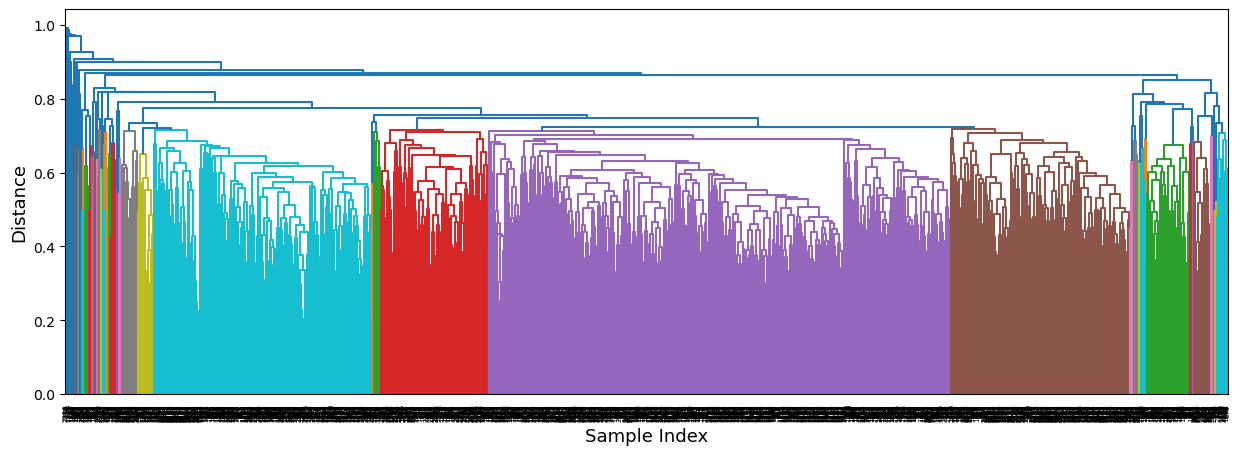


=== CLUSTER SUMMARY (threshold=0.7182) ===
Total clusters: 55
Clusters with >1000 samples: 0
Clusters with >30 samples: 8

Cluster sizes:
cluster
1     959
2     450
3     372
4     224
5      89
6      36
7      34
8      34
9      23
10     14
11     12
12     11
14      9
15      9
13      9
17      7
16      7
18      6
19      6
20      6
21      6
22      6
23      6
24      6
25      5
26      5
29      4
30      4
28      4
27      4
dtype: int64


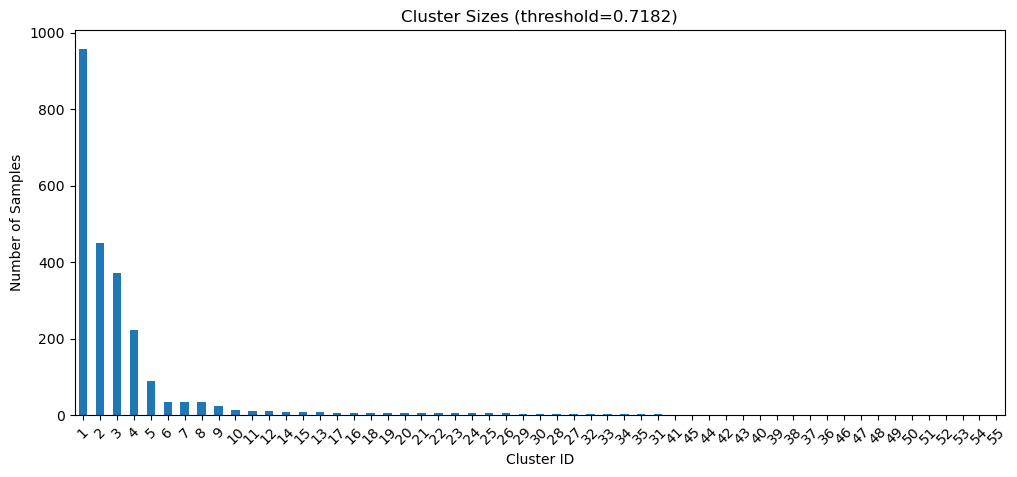

In [9]:
from scipy.cluster.hierarchy import dendrogram 

linked_jaccard = linkage(dist_matrix_jac, method='average')

cluster_threshold = 0.7182
plt.figure(figsize=(15, 5))
dendrogram(linked_jaccard, color_threshold=cluster_threshold) # you can change this value to change the number of clusters you get
plt.xlabel("Sample Index", fontsize=13)
plt.ylabel("Distance", fontsize=13)
plt.show()

# First assign clusters using fcluster
agg_df['cluster'] = fcluster(linked_jaccard, t=cluster_threshold, criterion='distance')
fish_df['cluster'] = agg_df['cluster']

# Then reassign cluster numbers in order by cluster size (largest = 1)
cluster_sizes = agg_df['cluster'].value_counts().sort_values(ascending=False)
cluster_map = {old: new for new, old in enumerate(cluster_sizes.index, 1)}
agg_df['cluster'] = agg_df['cluster'].map(cluster_map)
fish_df['cluster'] = agg_df['cluster']

# Summary of clusters
cluster_summary = agg_df.groupby('cluster').size().sort_values(ascending=False)
print(f"\n=== CLUSTER SUMMARY (threshold={cluster_threshold}) ===")
print(f"Total clusters: {len(cluster_summary)}")
print(f"Clusters with >1000 samples: {(cluster_summary >= 1000).sum()}")
print(f"Clusters with >30 samples: {(cluster_summary >= 30).sum()}")
print(f"\nCluster sizes:")
print(cluster_summary.head(30))

# Visualize cluster size distribution
plt.figure(figsize=(12, 5))
cluster_summary.plot(kind='bar')
plt.xlabel('Cluster ID')
plt.ylabel('Number of Samples')
plt.title(f'Cluster Sizes (threshold={cluster_threshold})')
plt.xticks(rotation=45);
#print(agg_df.groupby('cluster').size())

In [10]:
# Save for heatmap in 3cluster_visualization
agg_df.to_csv('pandas/agg_df_cluster1.csv', index=False)
fish_df.to_csv('pandas/fish_df_cluster1.csv', index=False)